<center><img src="https://matematica.usm.cl/wp-content/themes/dmatUSM/assets/img/logoDMAT2.png" title="Title text" width= 800 /></center>
<hr style="height:2px;border:none"/>
<h1 align='center'> Ayudantía 3: Introducción a Series Temporales en Python</h1>

<H3 align='center'> MAT281 2024-2 </H3>

<H3 align='center'> Ayud. Diego Astaburuaga C. </H3>
<hr style="height:2px;border:none"/>

> Referencia principal (Copiado desde): [Francisco Alfaro](https://colab.research.google.com/github/fralfaro/MAT281_2024/blob/main/docs/lectures/machine_learning/ts_01.ipynb).

In [42]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# graficos incrustados
sns.set_style("whitegrid")
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

## Toolkit

In [43]:
# Caja de Herramientas

from statsmodels.graphics.tsaplots import plot_acf # acf
from statsmodels.graphics.tsaplots import plot_pacf # pacf
from statsmodels.tsa.stattools import adfuller # test estacionalidad

from statsmodels.tsa.statespace.sarimax import SARIMAX #.fit .get_prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
def box_transformations(y,param):
    if param>0:
        return y.apply(lambda x: (x**(param)-1)/param)
    elif param==0:
        return np.log(y)
    else:
        print("lambda es negativo, se devulve la serie original")
        return y

## Debo acordarme de borrar esto (punteo de ideas)

---

Contenidos a ver según las clases de Series de Tiempo
- Modelos AR, MA, ARMA, ARIMA, SARIMA, etc.
- diferenciacion de las series.
- decompose
- Graficos de dispersion Rn vs Rn-1. etc.
- ACF y PACF.
- Entrenamiento y validación cruzada.

---

---

Propuesta para al ayudantía:
 
- Empezar motivando con lo mostrado en el documento de Alfaro.
    - Análisis de las series
        - Gráficos descriptivos.
        - Descomposición STL.
        - Estacionariedad.
    - Forecast (predicción)
        - Modelos.
        - Aplicación.
        - Residuos.

---

Algunas consideraciones:
- No existe un metodo o procedimiento estandar para analizar series de tiempo, hay que ser creativos o estudiar el contexto de los datos.
- Es importante que los datos esten ordenados en fecha.
- Hay que definir el problema a abordar: forecasting, detectar anomalias, modelar la volatilidad, hallar patrones temporales, etc.

---

**transformaciones de Box-Cox**:  
 $$Y_{t} = \left\{\begin{matrix}
\dfrac{X_{t}^{\lambda}-1}{\lambda}, \ \  \textrm{si }  \lambda > 0\\ 
\textrm{log}(X_{t}), \ \  \textrm{si }  \lambda = 0
\end{matrix}\right.$$

## Introducción

* Una [serie temporal](https://en.wikipedia.org/wiki/Time_series) o cronológica es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.). 


* Uno de los usos más habituales de las series de datos temporales es su análisis para **predicción** y **pronóstico** (así se hace por ejemplo con los datos climáticos, las acciones de bolsa, o las series de datos demográficos). Resulta difícil imaginar una rama de las ciencias en la que no aparezcan datos que puedan ser considerados como series temporales. Las series temporales se estudian en estadística, procesamiento de señales, econometría y muchas otras áreas.

## Análisis de series temporales

Para análizar series temporales, es importante muchas veces (al igual que en otros problemas) el contexto de donde provienen los datos. Para fijar ideas, trabajaremos de momento con el conjunto de datos `AirPassengers.cvs`.

### Descripción del problema

El conjunto mencionado contiene la información del total de pasajeros (a nivel de mes) entre los año 1949 y 1960. En terminos estadísticos, el problema puede ser presentado por la serie temporal $\{X_t:t\in T\}$, donde:

- $X_t$: corresponde al total de pasajeros en el tiempo t,
- $t$: tiempo medido a nivel de mes.

El objetivo es poder desarrollar un modelo predictivo que me indique el número de pasajeros para los próximos dos años. Antes de ajustar el modelo, se debe entender el comportamiento de la serie de tiempo en estudio y con esta información, encontrar el modelo que mejor se puede ajustar (en caso que exista).

Como son muchos los conceptos que se presentarán, es necesario ir apoyandose con alguna herramienta de programación, en nuestro caso python. Dentro de python, la librería statsmodels es ideal para hacer este tipo de análisis.

In [45]:
# cargar datos

df = pd.read_csv("../datasets/AirPassengers.csv", sep=",")
df.columns = ['date','passengers']
df.head()

,date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [46]:
# resumen
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [47]:
# fechas
print('Fecha Inicio: {}\nFecha Fin:    {}'.format(df.date.min(),df.date.max()))

Fecha Inicio: 1949-01
Fecha Fin:    1960-12


Tratamiento de datos, datos perdidos, datetime format, etc.

Media, varianza.

funciones utiles: rolling, diff

In [48]:
# formato datetime de las fechas
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# dejar en formato ts
y = df.set_index('date').resample('ME').mean()

y.head()

,passengers
date,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0


In [74]:
type(y)

pandas.core.frame.DataFrame

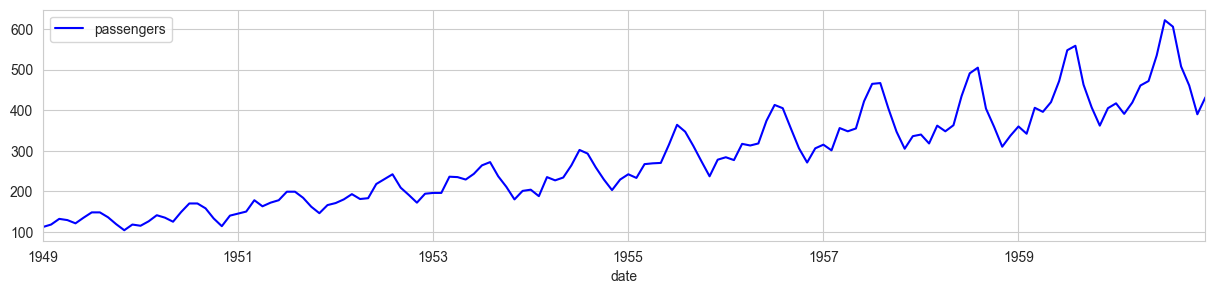

In [49]:
# graficar datos
y.plot(figsize=(15, 3),color = 'blue')
plt.show()

¿Que podemos decir de la serie?

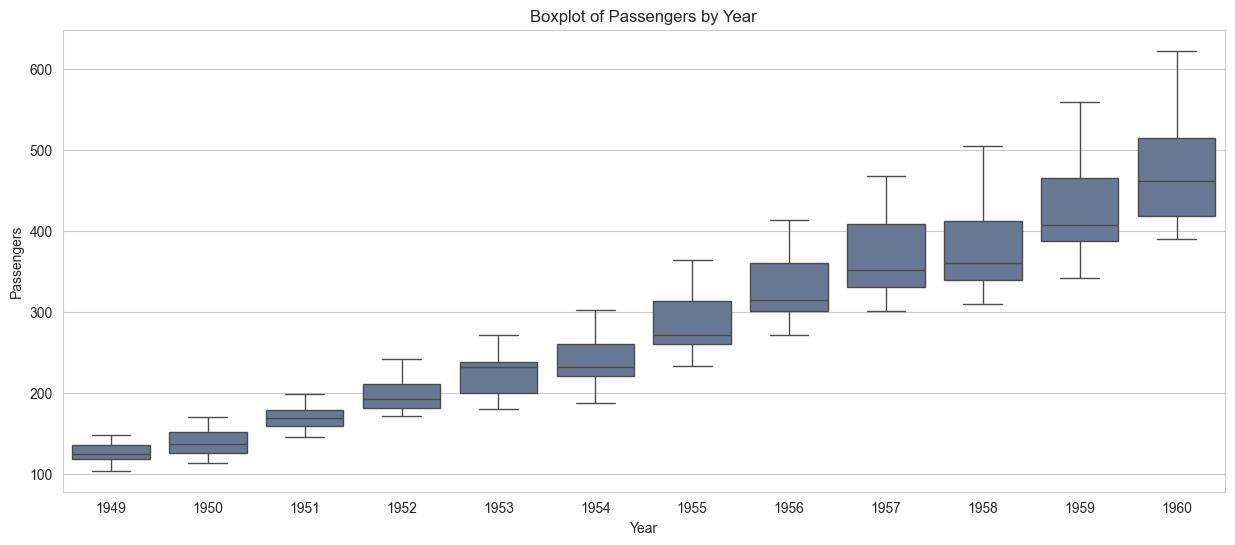

In [50]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x=y.index.year, y=y["passengers"], data=y, ax=ax)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.title("Boxplot of Passengers by Year")

# Display the plot
plt.show()

### Descomposición STL

Una serie temporal la podemos descomponer en tres componentes:

 * **tendencia** ($T$): trayectoria de los datos en el tiempo (dirección positiva o negativa).
 * **estacionalidad**($S$):  fluctuaciones regulares y predecibles en un periodo determinado (anual, semestral,etc.)
 * **ruido**($e$): error intrínsico al tomar una serie temporal (instrumenos, medición humana, etc.) 
 
Cuando un descompone la serie temporla en sus tres componenctes (tendencia, estacionalidad, ruido) se habla de **descompocisión STL**. En muchas ocasiones no es posible descomponer adecuadamente la serie temporal, puesto que la muestra obtenida no presenta un comportamiento ciclico o repetitivo en el periodo de tiempo analizado.

Por otro lado, esta descomposición se puede realizar de dos maneras diferentes: 

* **Aditiva**: $$X_{t} = T_{t} + S_{t} + e_{t}$$
* **Multiplicativa**: $$X_{t} = T_{t} * S_{t} * e_{t}$$


Por supuesto esta no es la única forma de descomponer una serie, pero sirve como punto de partida para comprender nuestra serie en estudio.

Realizaremos un descomposición del tipo multiplicativa, ocupando el comando de statsmodels **seasonal_decompose**.

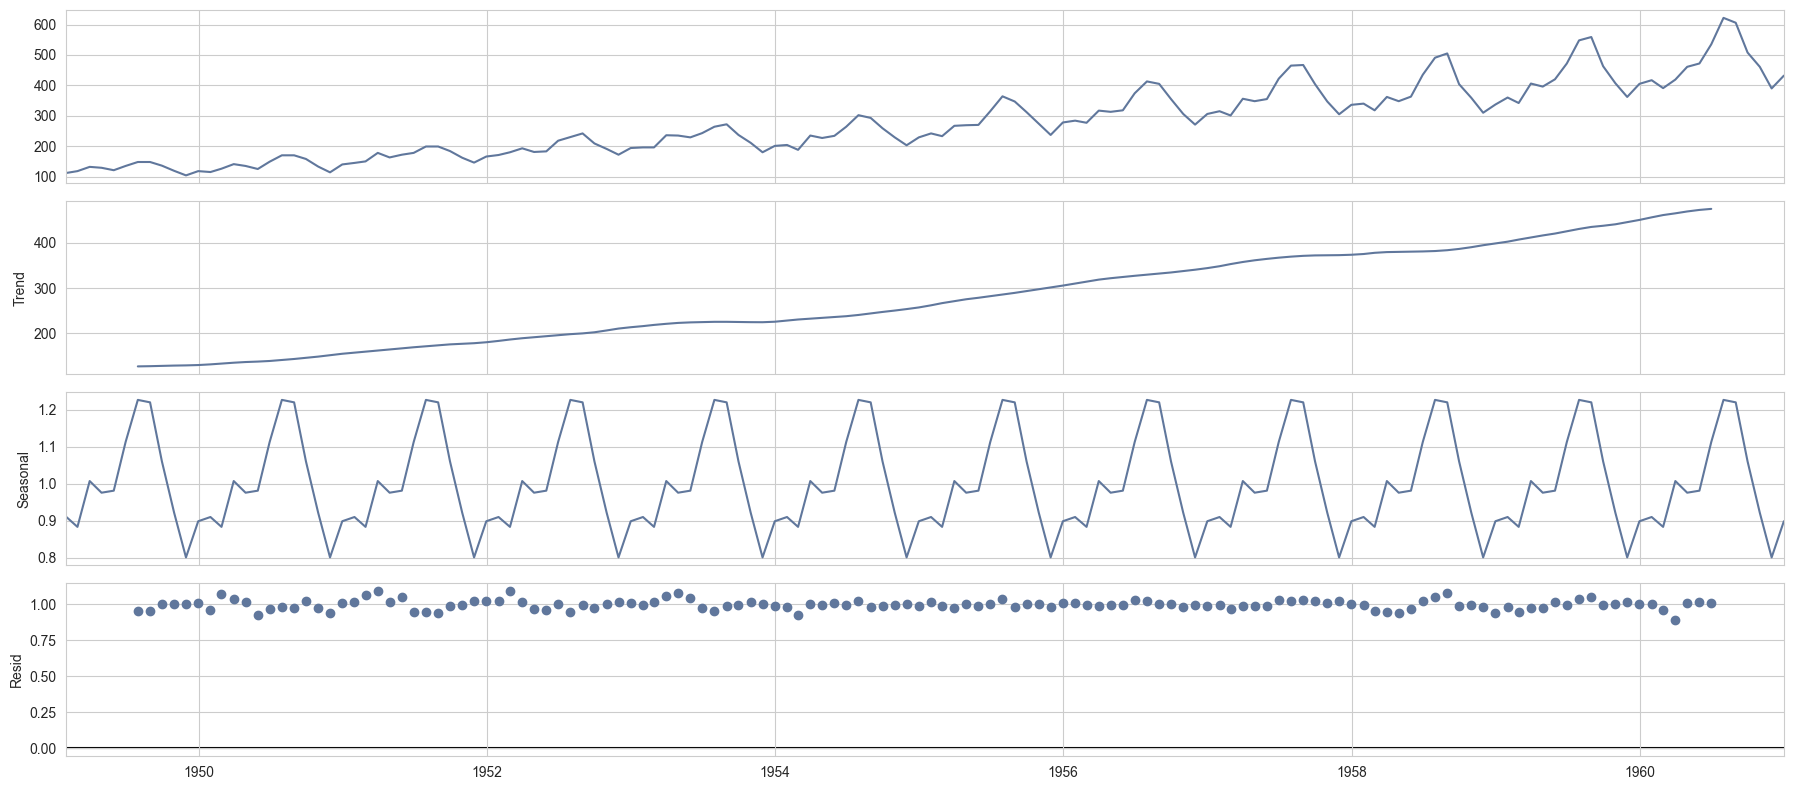

In [51]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

Analicemos cada uno de estos gráficos:

* **gráfico 01** (serie original): este gráfico simplemente nos muestra la serie original graficada en el tiempo.


* **gráfico 02** (tendencia): este gráfico nos muestra la tendencia de la serie, para este caso, se tiene una tendencial lineal positiva.


* **gráfico 03** (estacionariedad): este gráfico nos muestra la estacionariedad de la serie, para este caso, se muestra una estacionariedad año a año, esta estacionariedad se puede ver como una curva invertida (función cuadrática negativa), en donde a aumenta hasta hasta a mediados de años (o un poco más) y luego esta cae suavemente a final de año.


* **gráfico 04** (error): este gráfico nos muestra el error de la serie, para este caso, el error oscila entre 0 y 1. En general se busca que el error sea siempre lo más pequeño posible y que tenga el comportamiento de una distribución normal. Cuando el error sigue una distribución normal con media cero y varianza 1, se dice que el error es un **ruido blanco**.

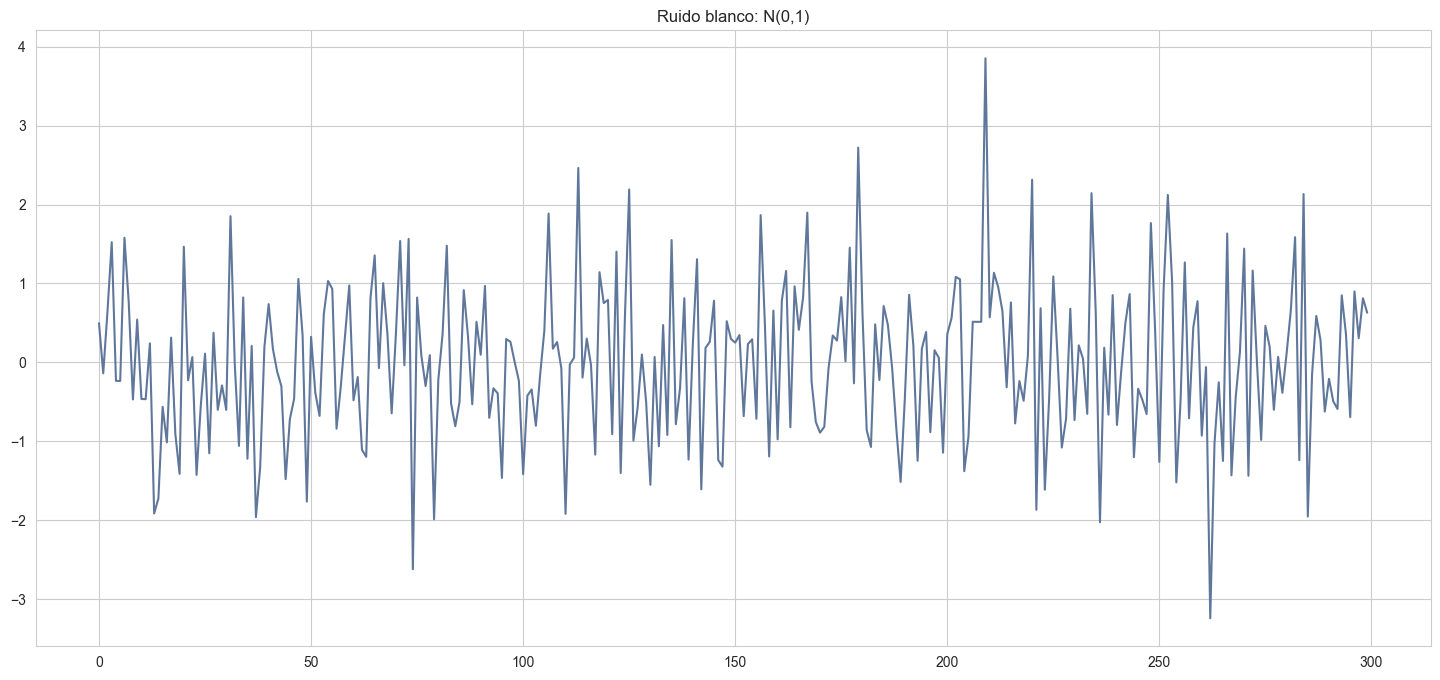

In [52]:
# grafico: lineplot 

np.random.seed(42) # fijar semilla

mean = 0
std = 1 
num_samples = 300


samples = np.random.normal(mean, std, size=num_samples)

plt.plot(samples)
plt.title("Ruido blanco: N(0,1)")
plt.show()

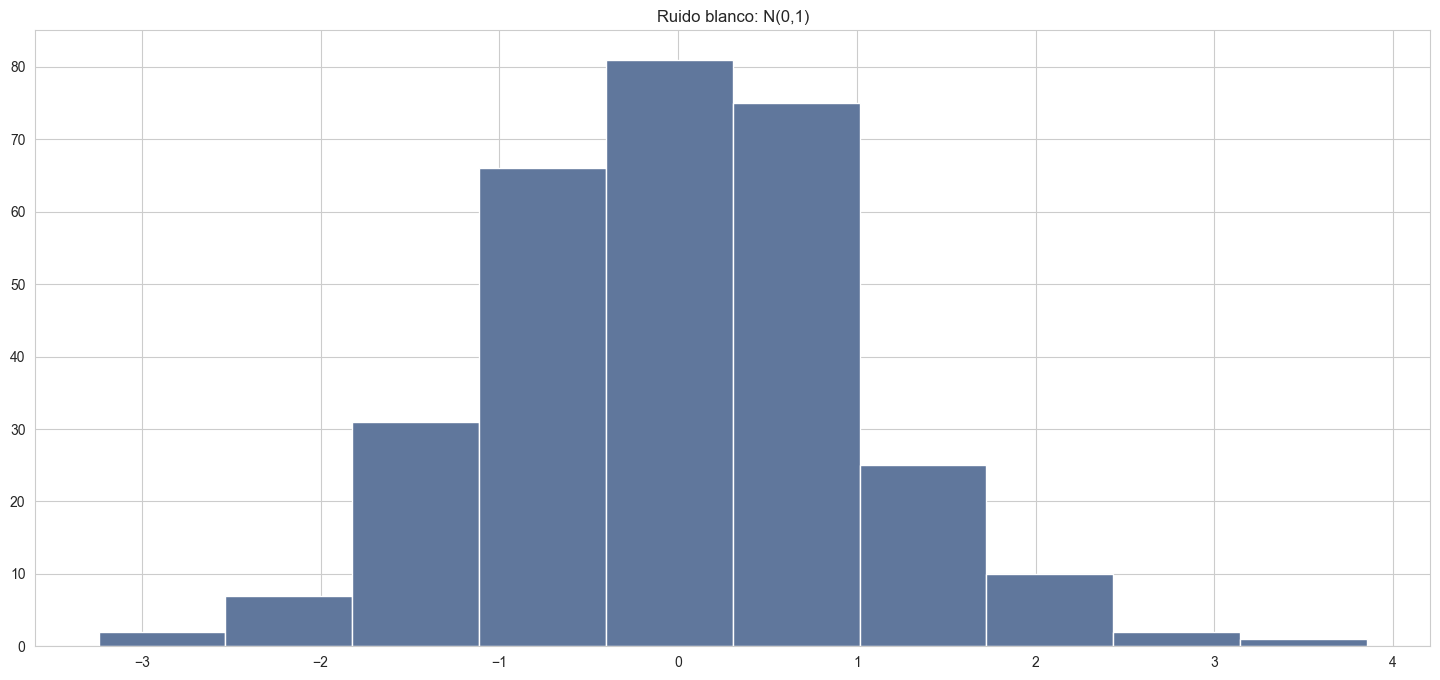

In [53]:
# grafico: histograma
plt.hist(samples,bins = 10)
plt.title("Ruido blanco: N(0,1)")
plt.show()

### Series Estacionarias 

Un concepto importante para el ánalisis de series temporales, es el concepto de estacionariedad. 

#### Definición
Sea $\left \{ X_t: t \in T \right \}$ una serie temporal. Se dice que una serie temporal es **débilmente estacionaria** si:

 * $\mathbb{V}(X_t) < \infty$, para todo $t \in T$.
 * $\mu_{X}(t)= \mu$, para todo $t \in T$.
 * $\gamma_{X}(r,s)= \gamma_{X}(r+h,s+h)=\gamma_{X}(h)  $, para todo $r,s,h\in T$.

En palabras simple, una serie temporal es débilmente estacionaria si varía poco respecto a su propia media.

**¿ Por qué es importante este concepto ?**

* Supuesto base de muchos modelos de series temporales (desde el punto de vista estadístico)
* No se requiere muchas complicaciones extras para que las predicciones sean "buenas".

**Autocorrelación (ACF) y autocorrelación parcial PACF**

Definamos a grandes rasgos estos conceptos:

* **Función de autocorrelación** (ACF). En el retardo $k$, es la autocorrelación entre los valores de las series que se encuentran a $k$ intervalos de distancia.


* **Función de autocorrelación parcial** (PACF). En el retardo $k$, es la autocorrelación entre los valores de las series que se encuentran a $k$ intervalos de distancia, teniendo en cuenta los valores de los intervalos intermedios.


Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una rápida disminución de la correlación después de un pequeño retraso entre los puntos.

Gráfiquemos la acf y pacf de nuestra serie temporal ocupando los comandos **plot_acf** y **plot_pacf**, respectivamente.

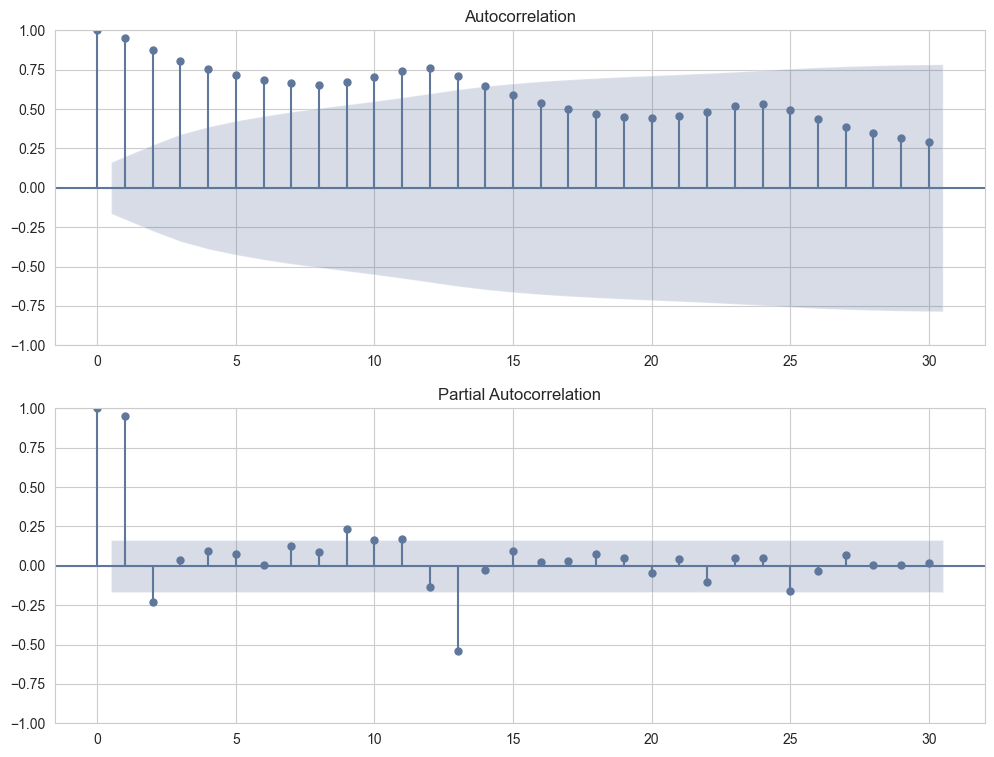

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

> ¿Para que sirve esto?

**Prueba  Dickey-Fuller**

En estadística, la prueba Dickey-Fuller prueba la hipótesis nula de que una raíz unitaria está presente en un modelo autorregresivo. La hipótesis alternativa es diferente según la versión de la prueba utilizada, pero generalmente es estacionariedad o tendencia-estacionaria. Lleva el nombre de los estadísticos David Dickey y Wayne Fuller, quienes desarrollaron la prueba en 1979.

Para efectos práticos, para el caso de estacionariedad se puede definir el test como:

* **Hipótesis nula**: la serie temporal no es estacionaria.
* **Hipótesis alternativa**: la serie temporal es alternativa.


Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionariedad

In [55]:
from statsmodels.tsa.stattools import adfuller

#test Dickey-Fulle:
print ('Resultados del test de Dickey-Fuller:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64


**¿ Qué se puede hacer si la serie no es etacionaria ?**

Nuestro caso en estudio resulto ser una serie no estacionaria, no obstante, se pueden realizar tranformaciones para solucionar este problema.

Como es de esperar, estas tranformaciones deben cumplir ciertas propiedades (inyectividad, diferenciables, etc.). A continuación, se presentan algunas de las tranformaciones más ocupadas en el ámbito de series temporales:

Sea $X_{t}$ una serie temporal, entonces uno puede definir una nueva serie temporal $Y_{t}$ de la siguiente manera:

 * **diferenciación**:  $Y_{t} =\Delta X_{t}  =X_{t}-X_{t-1}$.
 
 
 * **transformaciones de Box-Cox**:  
 $$Y_{t} = \left\{\begin{matrix}
\dfrac{X_{t}^{\lambda}-1}{\lambda}, \ \  \textrm{si }  \lambda > 0\\ 
\textrm{log}(X_{t}), \ \  \textrm{si }  \lambda = 0
\end{matrix}\right.$$

Ayudemonos con python para ver el resultado de las distintas transformaciones.

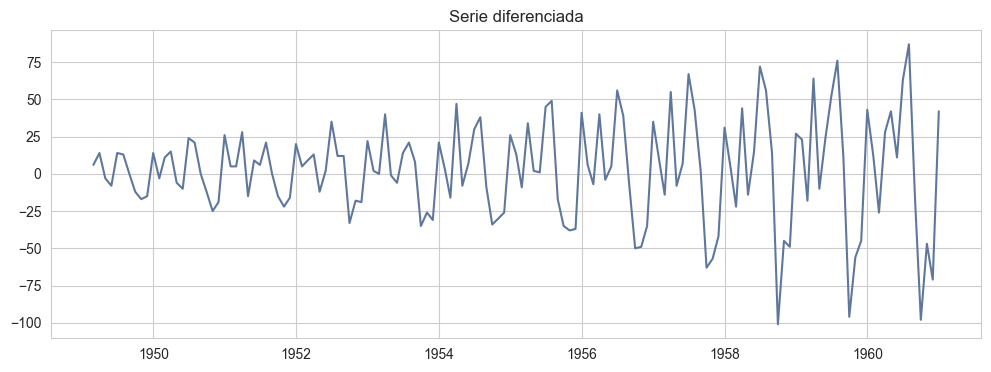

In [56]:
# diferenciacion

Y_diff = y.diff()

rcParams['figure.figsize'] = 12, 4
plt.plot(Y_diff)
plt.title("Serie diferenciada")
plt.show()

In [57]:
def box_transformations(y,param):
    if param>0:
        return y.apply(lambda x: (x**(param)-1)/param)
    elif param==0:
        return np.log(y)
    else:
        print("lambda es negativo, se devulve la serie original")
        return y

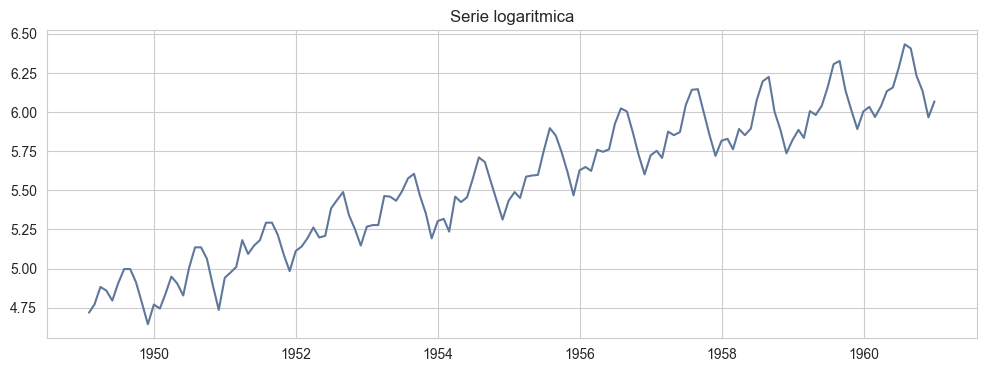

In [58]:
# logaritmo

Y_log = box_transformations(y,0)

rcParams['figure.figsize'] = 12, 4
plt.plot(Y_log)
plt.title("Serie logaritmica")
plt.show()

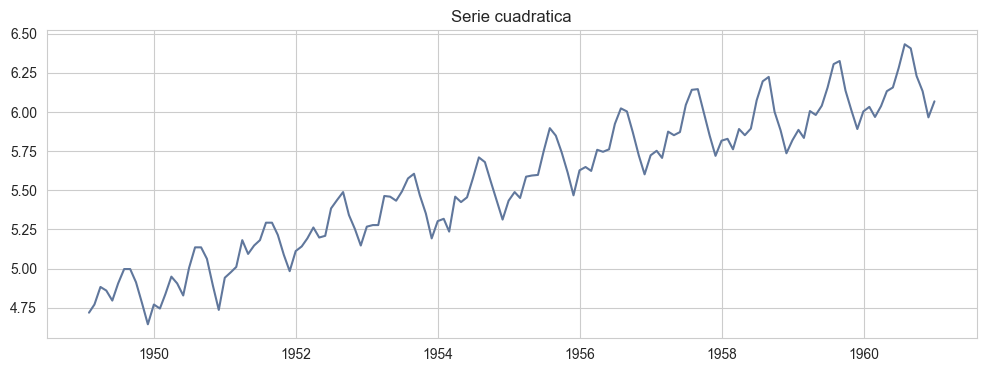

In [59]:
# cuadratica

Y_quad = box_transformations(y,2)

rcParams['figure.figsize'] = 12, 4
plt.plot(Y_log)
plt.title("Serie cuadratica")
plt.show()

### Estadísticos Rolling

In [60]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

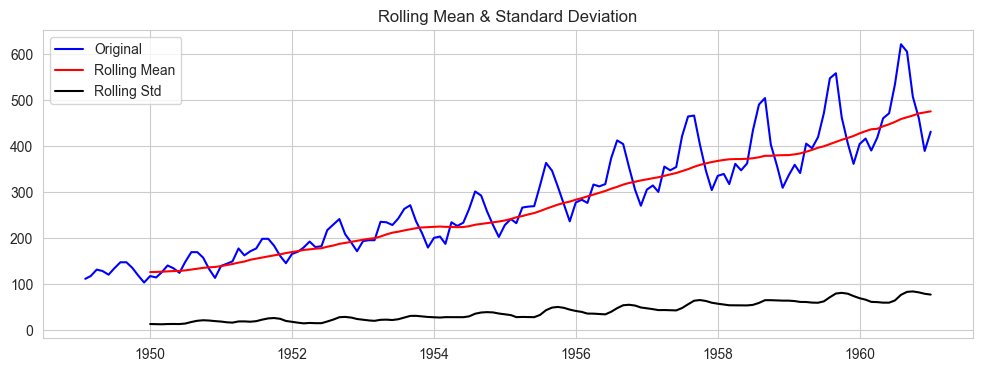

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [61]:
test_stationarity(y)

## Modelos de forecast  (Pronóstico)

Para realizar el pronóstico de series, existen varios modelos clásicos para analizar series temporales:

**Modelos con variabilidad (varianza) constante**

* **Modelos de media móvil** (MA(d)): el modelo queda en función de los ruidos $e_{1},e_{2},...,e_{d}$
    
* **Modelos autorregresivos** (AR(q)): el modelo queda en función de los ruidos $X_{1},X_{2},...,X_{q}$
    
* **Modelos ARMA**  (ARMA(p,q)): Mezcla de los modelos $MA(d)$ y $AR(q)$
    
* **Modelos ARIMA** (ARIMA(p,d,q)):: Mezcla de los modelos $MA(d)$ y $AR(q)$ sobre la serie diferenciada $d$ veces.
 
* **Modelos SARIMA** (SARIMA(p,d,q)x(P,D,Q,S)): Mezcla de los modelos ARIMA(p,d,q) agregando componentes de estacionariedad ($S$).
    
Dentro de estos modelos, se tiene que uno son un caso particular de otro más general:

$$MA(d),AR(q) \subset ARMA(p,q) \subset ARIMA(p,d,q)  \subset SARIMA(p,d,q)x(P,D,Q,S)  $$
    
 
    
**Modelos de volatibilidad**

* **Arch**

* **Garch**

* **Modelos de espacio estado**

### Realizar pronóstico con statsmodels

El pronóstico lo realizaremos ocupando los modelos disponible en statsmodels, particularmen los modelos $SARIMA(p,d,q)x(P,D,Q,S)$.

Como todo buen proceso de machine learning es necesario separar nuestro conjunto de datos en dos (entrenamiento y testeo). ¿ Cómo se realiza esto con series temporales ?.

El camino correcto para considerar una fecha objetivo (**target_date**), el cual separé en dos conjuntos, de la siguiente manera:

* **y_train**: todos los datos hasta la fecha **target_date**
* **y_test**: todos los datos después la fecha **target_date**

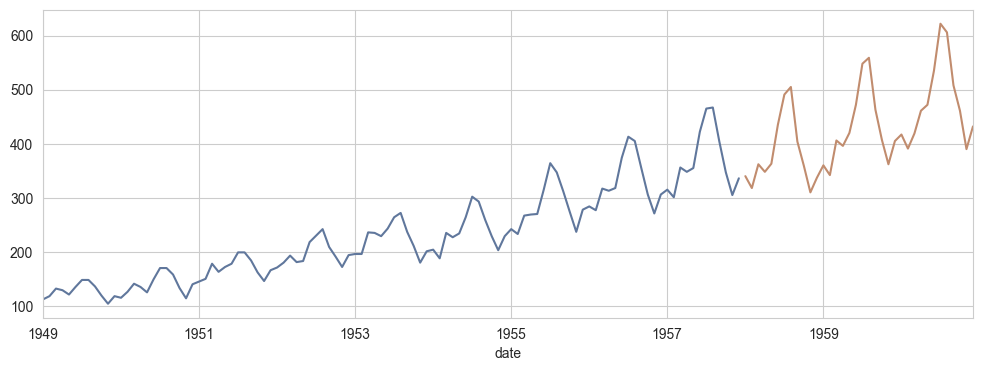

In [62]:
target_date =  '1958-01-01'

# crear conjunto de entrenamiento y de testeo
mask_ds = y.index < target_date

y_train = y[mask_ds]
y_test = y[~mask_ds]

#plotting the data
y_train['passengers'].plot()
y_test['passengers'].plot()
plt.show()

> Revisar Backtesting en https://cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn

Una pregunta natural que surgue es: ¿ por qué no se toman datos de manera aleatoria?. 

La respuesta es que como se trabaja el la variable **tiempo**, por lo tanto los datos siguen un orden natural de los sucesos, en cambio, en los problemas de regresión no existe orden en los sucesos, por cada par de punto es de cierta forma **independiente** uno con otros. Además, si se sacarán puntos de testeo de manera aleatoria, podría romper con la tendencia y estacionariedad original de la serie.

Veamos un ejemplo sensillo de este caso en python:

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def regression_metrics(df):
    """
    Aplicar las distintas métricas definidas
    :param df: DataFrame con las columnas: ['y', 'yhat']
    :return: DataFrame con las métricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mean_absolute_error(y_true, y_pred), 4)]
    df_result['mse'] = [round(mean_squared_error(y_true, y_pred), 4)]
    df_result['rmse'] = [round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)]
    df_result['mape'] = [round(mean_absolute_percentage_error(y_true, y_pred), 4)]
    df_result['smape'] = [round(2 * mean_absolute_percentage_error(y_true, y_pred) / (mean_absolute_percentage_error(y_true, y_pred) + 100), 4)]

    return df_result

In [64]:
# parametros
param = [(1,0,0),(0,0,0,12)]

# modelo
model = SARIMAX(y_train,
                        order=param[0],
                        seasonal_order=param[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
# ajustar modelo
model_fit = model.fit(disp=0)

# fecha de las predicciones        
start_index = y_test.index.min()
end_index = y_test.index.max()

preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
df_temp = pd.DataFrame(
            {
                'y':y_test['passengers'],
                'yhat': preds.predicted_mean
            }
        )

# resultados del ajuste
df_temp.head()

,y,yhat
1958-01-31,340.0,336.756041
1958-02-28,318.0,337.513783
1958-03-31,362.0,338.273230
1958-04-30,348.0,339.034386
1958-05-31,363.0,339.797254


In [65]:
# resultados de las métricas
df_metrics = regression_metrics(df_temp)
df_metrics['model'] = f"SARIMA_{param[0]}X{param[1]}".replace(' ','')
df_metrics

,mae,mse,rmse,mape,smape,model
0,81.8529,11619.4305,107.7935,17.0068,0.2907,"SARIMA_(1,0,0)X(0,0,0,12)"


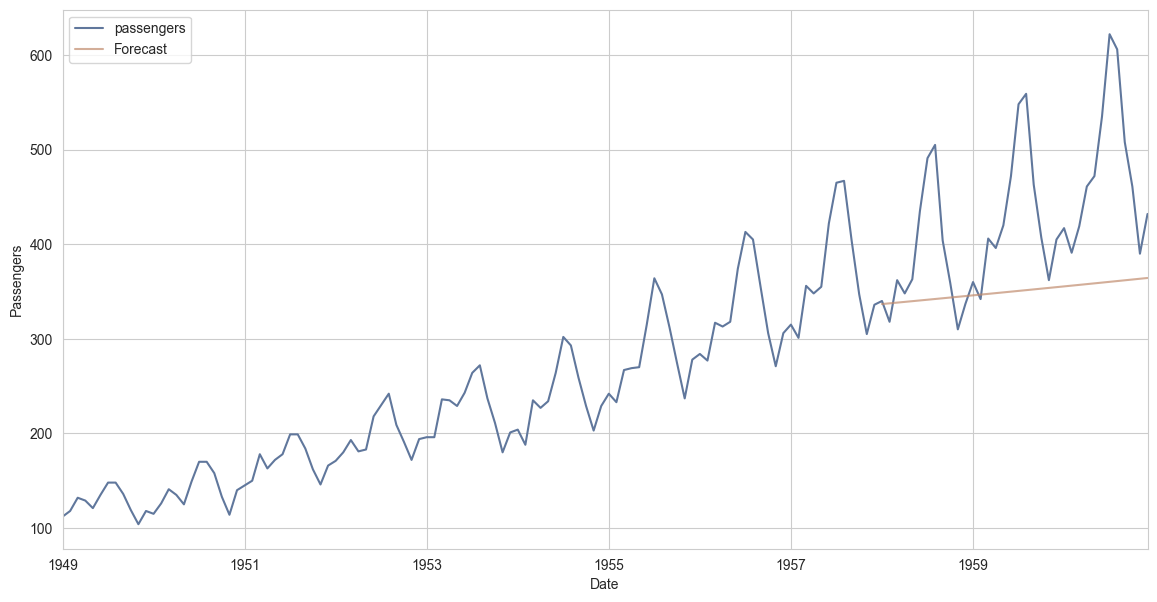

In [66]:
# graficamos resultados

preds = df_temp['yhat']
ax = y['1949':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

Observamos a simple vista que el ajuste no es tan bueno que digamos (analizando las métricas y el gráfico).

Entonces, ¿qué se puede hacer?. La respuesta es simple ¡probar varios modelos SARIMA!

Ahora, ¿ cómo lo hacemos? Lo primero es definir una clase llamada `SarimaModels` que automatice el proceso anterior, y nos quedamos con aquel modelo que minimice alguna de las métricas propuestas, por ejemplo, minimizar las métricas de **mae** y **mape**.

In [67]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['passengers'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = regression_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

In [68]:
# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '1958-01-01'

In [69]:
# iterar para los distintos escenarios

frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y,target_date)
        frames.append(df_metrics)
    except:
        pass

C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
# juntar resultados de las métricas y comparar
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,smape,model
0,16.4272,406.5114,20.1621,4.1002,0.0788,"SARIMA_(0,1,0)X(1,0,0,12)"
0,17.7173,469.8340,21.6757,4.2001,0.0806,"SARIMA_(0,1,1)X(1,1,1,12)"
0,17.7204,480.9764,21.9312,4.1431,0.0796,"SARIMA_(1,1,0)X(1,1,1,12)"
0,17.8053,501.0603,22.3844,4.1164,0.0791,"SARIMA_(1,1,1)X(0,1,0,12)"
0,17.8056,505.4167,22.4815,4.1061,0.0789,"SARIMA_(0,1,0)X(0,1,0,12)"
...,...,...,...,...,...,...
0,94.9444,14674.5556,121.1386,19.8867,0.3318,"SARIMA_(0,1,0)X(0,0,0,12)"
0,360.7115,150709.0664,388.2127,82.0329,0.9013,"SARIMA_(0,0,1)X(0,0,1,12)"
0,366.5303,153175.7993,391.3768,83.7030,0.9113,"SARIMA_(0,0,0)X(0,0,1,12)"
0,422.9626,187068.9748,432.5147,98.3713,0.9918,"SARIMA_(0,0,1)X(0,0,0,12)"


En este caso el mejor modelo resulta ser el modelo $SARIMA(0,1,0)X(1,0,0,12)$. Veamos gráficamente que tal el ajuste de este modelo.

In [71]:
# ajustar mejor modelo

param = [(0,1,0),(1,0,0,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y,target_date)
best_model = sarima_model.df_testig(y,target_date)
best_model.head()

,y,yhat
1958-01-31,340.0,345.765806
1958-02-28,318.0,330.574552
1958-03-31,362.0,390.254476
1958-04-30,348.0,381.573760
1958-05-31,363.0,389.169386


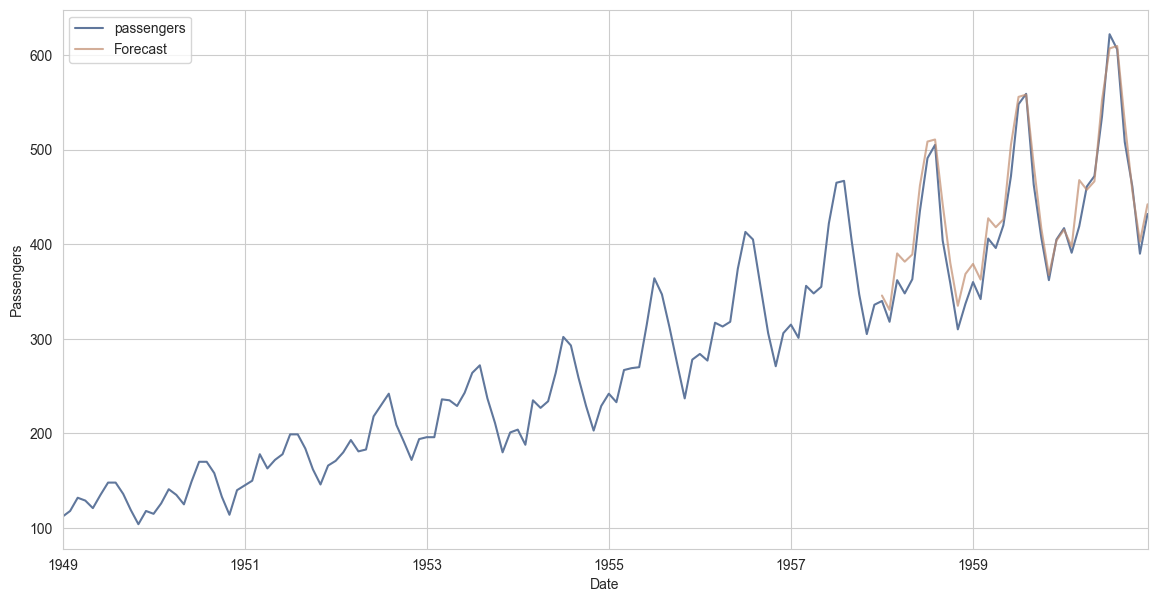

In [72]:
# graficar mejor modelo

preds = best_model['yhat']
ax = y['1949':].plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

Para este caso, el mejor modelo encontrado se ajusta bastante bien a los datos.

Finalmente, vemos algunos resultados del error asosciado al modelo. Para esto ocupamos la herramienta **plot_diagnostics**, el cual nos arroja cuatro gráficos analizando el error de diferentes manera.

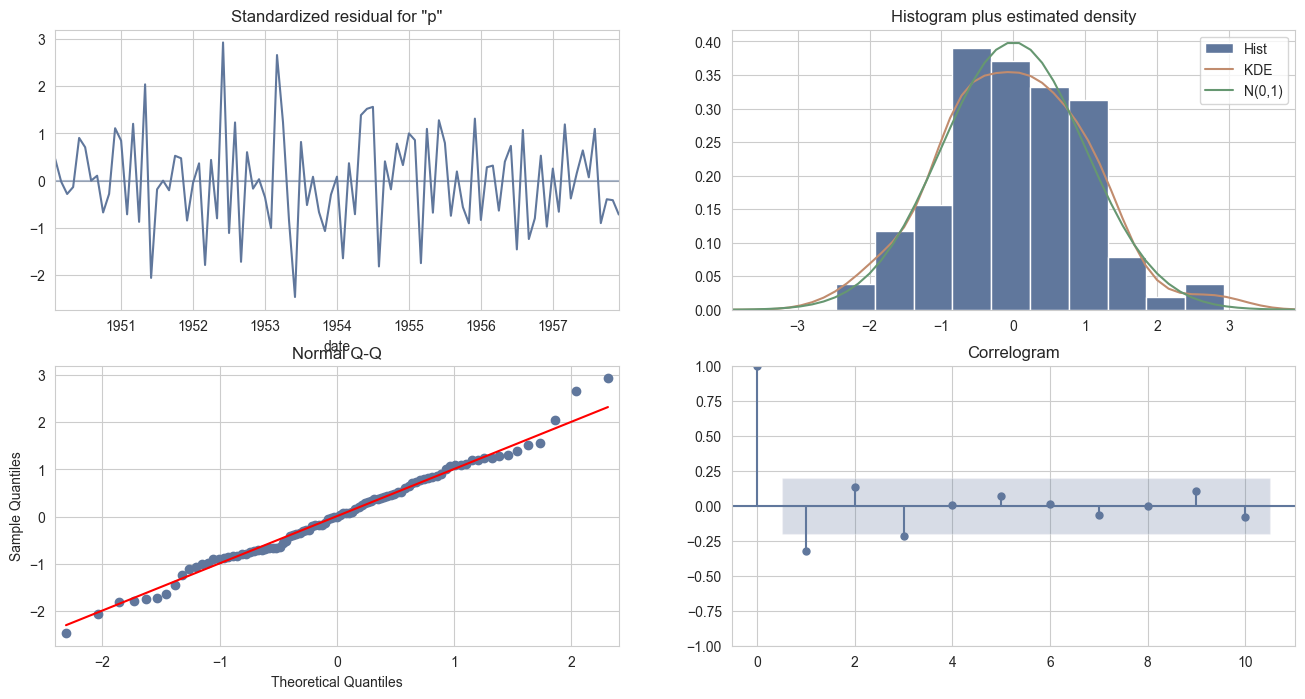

In [73]:
# resultados del error 
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

* **gráfico 01** (standarized residual): Este gráfico nos muestra el error estandarizado en el tiempo. En este caso se observa que esta nueva serie de tiempo corresponde a una serie estacionaria que oscila entorno al cero, es decir, un ruido blanco.


* **gráfico 02** (histogram plus estimated density): Este gráfico nos muestra el histograma del error. En este caso, el histograma es muy similar al histograma de una variable $\mathcal{N}(0,1)$ (ruido blanco).


* **gráfico 03** (normal QQ):  el gráfico Q-Q ("Q" viene de cuantil) es un método gráfico para el diagnóstico de diferencias entre la distribución de probabilidad de una población de la que se ha extraído una muestra aleatoria y una distribución usada para la comparación. En este caso se comparar la distribución del error versus una distribución normal. Cuando mejor es el ajuste lineal sobre los puntos, más parecida es la distribución entre la muestra obtenida y la distribución de prueba (distribución normal).




* **gráfico 04** (correlogram): Este gráfico nos muestra el gráfico de autocorrelación entre las variables del error, se observa que no hay correlación entre ninguna de las variables, por lo que se puedan dar indicios de independencia entre las variables.


En conclusión, el error asociado al modelo en estudio corresponde a un ruido blanco. 

> Hasta aquí la referencia principal (Extraido de): [Francisco Alfaro](https://colab.research.google.com/github/fralfaro/MAT281_2024/blob/main/docs/lectures/machine_learning/ts_01.ipynb).

## Referencias
- https://github.com/fralfaro/MAT281_2024/blob/main/docs/lectures/machine_learning/ts_01.ipynb
- https://www.youtube.com/watch?v=EXwiwWD2DkI
- https://cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
- https://arxiv.org/pdf/1302.6613